Objective

My goal is to train and validate a regression model to predict the age of an abalone based off a number of details. Our dataset contains info icluding the gender, weight, and size of avalones along with the number of rings they have, which we use as a proxy for age.

In [ ]:
# Import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor, RidgeCV
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
)

# For reproducibility
RNG = 42
np.random.seed(RNG)

Data Importation and Pre-processing

,gender_F,gender_I,gender_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.312904,0.321283,0.365813,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.463731,0.467025,0.481715,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.000000,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.000000,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.000000,0.000000,0.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,1.000000,1.000000,1.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,1.000000,1.000000,1.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000



Missing values per column:
gender_F          0
gender_I          0
gender_M          0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
Rings             0
dtype: int64
Number of duplicates: 0


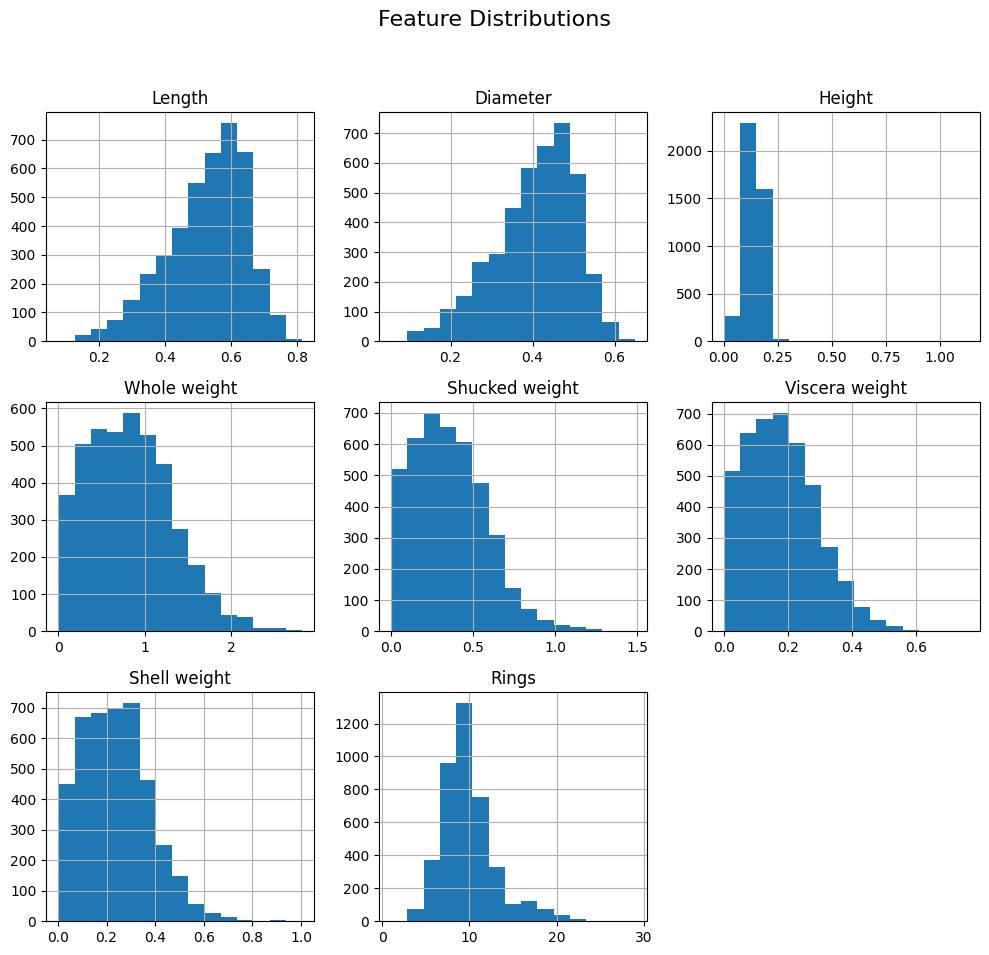

After pre-processing:


,gender_F,gender_I,gender_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,Rings
count,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.00000,4137.000000,4137.000000
mean,0.311578,0.323906,0.364515,0.522777,0.406773,0.138451,0.820887,0.356278,0.17907,0.236201,9.893401
std,0.463195,0.468021,0.481352,0.119681,0.098751,0.037550,0.482500,0.218651,0.10822,0.136094,3.189380
min,0.000000,0.000000,0.000000,0.075000,0.055000,0.010000,0.002000,0.001000,0.00050,0.001500,1.000000
25%,0.000000,0.000000,0.000000,0.450000,0.350000,0.115000,0.440500,0.185000,0.09250,0.130000,8.000000
50%,0.000000,0.000000,0.000000,0.540000,0.425000,0.140000,0.795000,0.334000,0.16900,0.230000,9.000000
75%,1.000000,1.000000,1.000000,0.615000,0.480000,0.165000,1.144500,0.498500,0.25050,0.325000,11.000000
max,1.000000,1.000000,1.000000,0.800000,0.630000,0.220000,2.657000,1.488000,0.64150,1.005000,29.000000


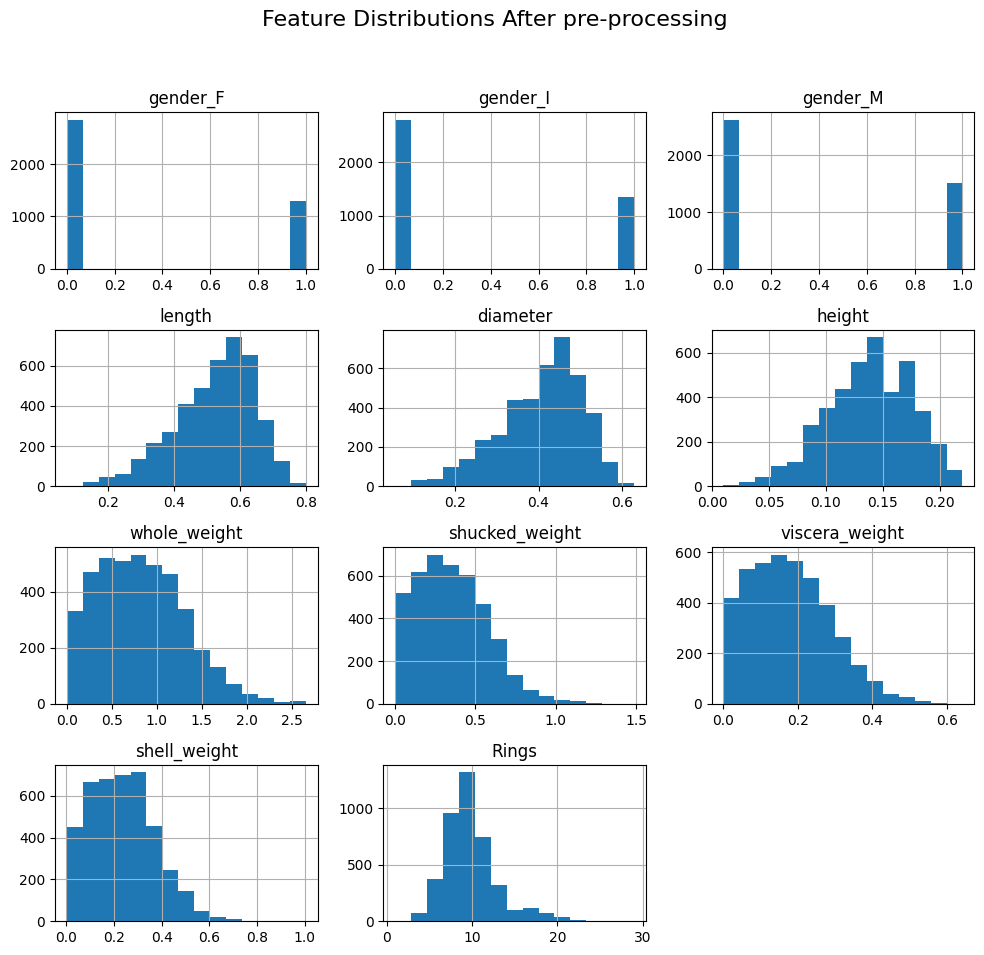

In [3]:
# dataset path
DATA_PATH = r"abalone.data.csv" 

# Load dataset as pandas DataFrame
df = pd.read_csv(DATA_PATH, sep=",")
assert "Rings" in df.columns, "Expected 'Rings' column." # Assert Rings column exists

# Converting gender to 3 separate one-hot encoded columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['gender'])  # Apply OneHotEncoder to column 3
    ],
    remainder='passthrough'  # Keep the other columns
)

datEnc = preprocessor.fit_transform(df)

# Get the new column names created by the transformer
new_columns = preprocessor.get_feature_names_out()

# Create a new DataFrame with the transformed data and new column names
dfEnc = pd.DataFrame(datEnc, columns=new_columns)
dfEnc = dfEnc.rename(columns={"cat__gender_F": "gender_F", "cat__gender_I": "gender_I", "cat__gender_M": "gender_M", "remainder__Length": "length", "remainder__Diameter": "diameter", "remainder__Height" : "height", "remainder__Whole weight" : "whole_weight", "remainder__Shucked weight": "shucked_weight", "remainder__Viscera weight" : "viscera_weight", "remainder__Shell weight" : "shell_weight", "remainder__Rings" : "Rings"})

# Summary statistics and check for missing values
display(dfEnc.describe(include='all'))
print("\nMissing values per column:")
print(dfEnc.isna().sum().sort_values(ascending=False))

# Check for duplicates
num_duplicates = dfEnc.duplicated().sum()
print(f"Number of duplicates: {num_duplicates}")

# Plot histograms for each feature
df.hist(bins=15, figsize=(10, 10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Remove entries with outliers in 'height' feature
height_threshold = dfEnc['height'].quantile(0.99)  # 99th percentile
dfEnc = dfEnc[dfEnc['height'] <= height_threshold]
dfEnc = dfEnc[dfEnc['height'] > 0]

# re-plot height distribution after removing outliers
print("After pre-processing:")
display(dfEnc.describe(include='all'))
dfEnc.hist(bins=15, figsize=(10, 10))
plt.suptitle("Feature Distributions After pre-processing", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Split data into features and target variable
X = dfEnc.drop(columns=["Rings"])
y_reg = dfEnc["Rings"]

# Split data into training and testing sets for regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=RNG
)

# Fold datasets for cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=RNG)

Testing Different algorithms

- Non-Negative Least Squares

- Ridge regression

- Lasso

- Elastic net

- Bayesian Ridge Regression

- Stochastic Gradient Decent

In [4]:

### Least square regression ###
nnls_alphas = [0, 1]
nnls_metrics = np.zeros([2, 8])

i = 0
for alphaTest in nnls_alphas:
    # Define Pipeline
    reg_pipe = Pipeline([
        ("scaler", RobustScaler()), # StandardScaler()),
        ("model", LinearRegression())
    ])

    # Cross Validate Pipeline
    cv_reg = cross_validate(
        reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
        scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
        return_train_score=True
    )  

    # Fit model on training data
    t0 = time.time()
    reg_pipe.fit(X_train_r, y_train_r)
    train_time = time.time() - t0

    # Predict on test data
    t1 = time.time()
    y_pred_r = reg_pipe.predict(X_test_r)
    pred_time = time.time() - t1

    # Save scores
    nnls_metrics[i, :] = [cv_reg['train_r2'].mean(), cv_reg['train_r2'].std(),       # Train R2      0:1
                           cv_reg['test_r2'].mean(), cv_reg['test_r2'].std(),         # Test R2       2:3
                           np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])),  # RMSE          4
                           -cv_reg['test_neg_mean_absolute_error'].mean(),            # MSE           5
                           train_time,                                                # Train time    6
                           pred_time]                                                 # Predict time  7

    i = i+1


In [5]:


### Ridge regression ###
ridge_alphas = np.linspace(0, 10, 10)
ridge_metrics = np.zeros([ridge_alphas.size, 8])

i = 0
for alphaTest in ridge_alphas:
    # Define Pipeline
    reg_pipe = Pipeline([
        ("scaler", RobustScaler()), # StandardScaler()),
        ("model", Ridge(alpha=alphaTest, random_state=RNG))
    ])

    # Cross Validate Pipeline
    cv_reg = cross_validate(
        reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
        scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
        return_train_score=True
    )  

    # Fit model on training data
    t0 = time.time()
    reg_pipe.fit(X_train_r, y_train_r)
    train_time = time.time() - t0

    # Predict on test data
    t1 = time.time()
    y_pred_r = reg_pipe.predict(X_test_r)
    pred_time = time.time() - t1

    # Save scores
    ridge_metrics[i, :] = [cv_reg['train_r2'].mean(), cv_reg['train_r2'].std(),       # Train R2      0:1
                           cv_reg['test_r2'].mean(), cv_reg['test_r2'].std(),         # Test R2       2:3
                           np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])),  # RMSE          4
                           -cv_reg['test_neg_mean_absolute_error'].mean(),            # MSE           5
                           train_time,                                                # Train time    6
                           pred_time]                                                 # Predict time  7

    i = i+1


c:\Users\Jude Robinson\OneDrive\Documents\uni\Into to AI\.venv\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.86806e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [6]:

### Lasso regression ###
lasso_alphas = np.linspace(1e-4, 1, 10)
lasso_metrics = np.zeros([lasso_alphas.size, 8])

i = 0
for alphaTest in lasso_alphas:
    # Define Pipeline
    reg_pipe = Pipeline([
        ("scaler", RobustScaler()), # StandardScaler()),
        ("model", Lasso(alpha=alphaTest, random_state=RNG, max_iter = 2000))
    ])

    # Cross Validate Pipeline
    cv_reg = cross_validate(
        reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
        scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
        return_train_score=True
    )  

    # Fit model on training data
    t0 = time.time()
    reg_pipe.fit(X_train_r, y_train_r)
    train_time = time.time() - t0

    # Predict on test data
    t1 = time.time()
    y_pred_r = reg_pipe.predict(X_test_r)
    pred_time = time.time() - t1

    # Save scores
    lasso_metrics[i, :] = [cv_reg['train_r2'].mean(), cv_reg['train_r2'].std(),       # Train R2      0:1
                           cv_reg['test_r2'].mean(), cv_reg['test_r2'].std(),         # Test R2       2:3
                           np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])),  # RMSE          4
                           -cv_reg['test_neg_mean_absolute_error'].mean(),            # MSE           5
                           train_time,                                                # Train time    6
                           pred_time]                                                 # Predict time  7

    i = i+1


In [7]:

### Elastic Net regression ###
elastic_alphas = np.linspace(1e-4, 1, 10)
elastic_l1s = np.linspace(1e-4, 1, 5)
elastic_metrics = np.zeros([elastic_alphas.size, elastic_l1s.size, 8])

i = 0
for alphaTest in elastic_alphas:
    n = 0
    for l1Test in elastic_l1s:
        # Define Pipeline
        reg_pipe = Pipeline([
            ("scaler", RobustScaler()), # StandardScaler()),
            ("model", ElasticNet(alpha=alphaTest, l1_ratio=l1Test, random_state=RNG, max_iter=2000))
        ])

        # Cross Validate Pipeline
        cv_reg = cross_validate(
            reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
            scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
            return_train_score=True
        )  

        # Fit model on training data
        t0 = time.time()
        reg_pipe.fit(X_train_r, y_train_r)
        train_time = time.time() - t0

        # Predict on test data
        t1 = time.time()
        y_pred_r = reg_pipe.predict(X_test_r)
        pred_time = time.time() - t1

        # Save scores
        elastic_metrics[i, n, :] = [cv_reg['train_r2'].mean(), cv_reg['train_r2'].std(),       # Train R2      0:1
                                    cv_reg['test_r2'].mean(), cv_reg['test_r2'].std(),         # Test R2       2:3
                                    np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])),  # RMSE          4
                                    -cv_reg['test_neg_mean_absolute_error'].mean(),            # MSE           5
                                    train_time,                                                # Train time    6
                                    pred_time]                                                 # Predict time  7
        n = n+1
    i = i+1

c:\Users\Jude Robinson\OneDrive\Documents\uni\Into to AI\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.547e+03, tolerance: 3.254e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Jude Robinson\OneDrive\Documents\uni\Into to AI\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.358e+01, tolerance: 3.254e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Jude Robinson\OneDrive\Documents\uni\Into to AI\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

In [8]:

### bayes regression ###
bayes_maxIters = np.linspace(5, 500, 10)
bayes_lambdas = np.linspace(0, 20, 5)
bayes_metrics = np.zeros([bayes_maxIters.size, bayes_lambdas.size, 8])

i = 0
for maxIterTest in bayes_maxIters:
    n = 0
    for lambdaTest in bayes_lambdas:
        # Define Pipeline
        reg_pipe = Pipeline([
            ("scaler", RobustScaler()), # StandardScaler()),
            ("model", BayesianRidge(max_iter=round(maxIterTest), lambda_init=lambdaTest, tol = 1e-6))
        ])

        # Cross Validate Pipeline
        cv_reg = cross_validate(
            reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
            scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
            return_train_score=True
        )  

        # Fit model on training data
        t0 = time.time()
        reg_pipe.fit(X_train_r, y_train_r)
        train_time = time.time() - t0

        # Predict on test data
        t1 = time.time()
        y_pred_r = reg_pipe.predict(X_test_r)
        pred_time = time.time() - t1

        # Save scores
        bayes_metrics[i, n, :] = [cv_reg['train_r2'].mean(), cv_reg['train_r2'].std(),       # Train R2      0:1
                                    cv_reg['test_r2'].mean(), cv_reg['test_r2'].std(),         # Test R2       2:3
                                    np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])),  # RMSE          4
                                    -cv_reg['test_neg_mean_absolute_error'].mean(),            # MSE           5
                                    train_time,                                                # Train time    6
                                    pred_time]                                                 # Predict time  7
        n = n+1
    i = i+1

In [9]:
### Stochastic gradient decent regression ###
sgdr_alphas = np.linspace(1e-4, 1, 10)
sgdr_l1s = np.linspace(1e-4, 1, 5)
sgdr_metrics = np.zeros([sgdr_alphas.size, sgdr_l1s.size, 8])

i = 0
for alphaTest in sgdr_alphas:
    n = 0
    for l1Test in sgdr_l1s:
        # Define Pipeline
        reg_pipe = Pipeline([
            ("scaler", RobustScaler()), # StandardScaler()),
            ("model", SGDRegressor(alpha=alphaTest, l1_ratio=l1Test, penalty= 'elasticnet', random_state=RNG, max_iter=2000))
        ])

        # Cross Validate Pipeline
        cv_reg = cross_validate(
            reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
            scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
            return_train_score=True
        )  

        # Fit model on training data
        t0 = time.time()
        reg_pipe.fit(X_train_r, y_train_r)
        train_time = time.time() - t0

        # Predict on test data
        t1 = time.time()
        y_pred_r = reg_pipe.predict(X_test_r)
        pred_time = time.time() - t1

        # Save scores
        sgdr_metrics[i, n, :] = [cv_reg['train_r2'].mean(), cv_reg['train_r2'].std(),      # Train R2      0:1
                                cv_reg['test_r2'].mean(), cv_reg['test_r2'].std(),         # Test R2       2:3
                                np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])),  # RMSE          4
                                -cv_reg['test_neg_mean_absolute_error'].mean(),            # MSE           5
                                train_time,                                                # Train time    6
                                pred_time]                                                 # Predict time  7
        n = n+1
    i = i+1

Plotting Results from different models

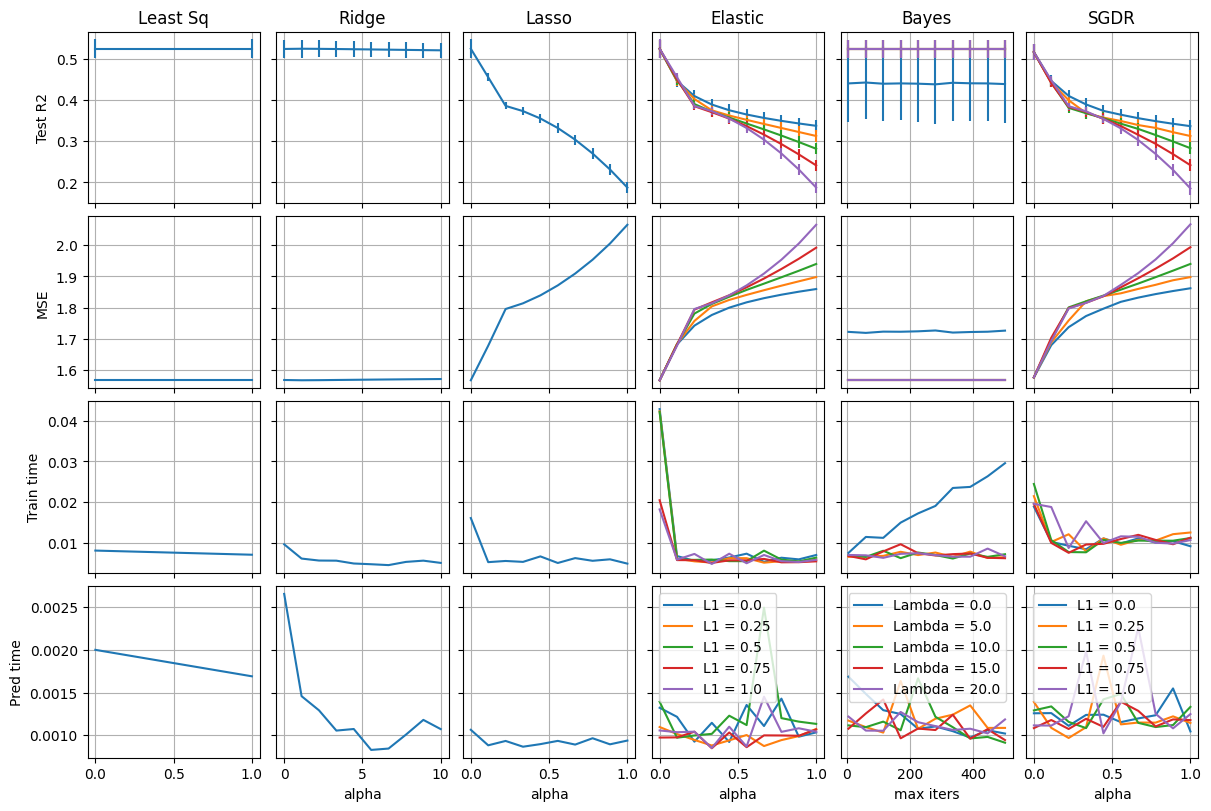

In [10]:
# Set up tiled layout
modelIndex = 0
fig, axs = plt.subplots(4, 6, 
                        sharey='row', 
                        sharex='col', 
                        figsize=(12, 8), 
                        constrained_layout=True)
#axs[0, 0].set(ylabel='Train R2')
axs[0, 0].set(ylabel='Test R2')
#axs[2, 0].set(ylabel='RMSE')
axs[1, 0].set(ylabel='MSE')
axs[2, 0].set(ylabel='Train time')
axs[3, 0].set(ylabel='Pred time')

for axX in np.arange(4):
    for axY in np.arange(6):
        axs[axX, axY].grid(True, which='both')

# Plot non-negative least square Metrics
axs[0, modelIndex].set(title='Least Sq')
#axs[0, modelIndex].errorbar(nnls_alphas, nnls_metrics[:, 0], yerr=nnls_metrics[:, 1])
axs[0, modelIndex].errorbar(nnls_alphas, nnls_metrics[:, 2], yerr=nnls_metrics[:, 3])
#axs[2, modelIndex].plot(nnls_alphas, nnls_metrics[:, 4])
axs[1, modelIndex].plot(nnls_alphas, nnls_metrics[:, 5])
axs[2, modelIndex].plot(nnls_alphas, nnls_metrics[:, 6])
axs[3, modelIndex].plot(nnls_alphas, nnls_metrics[:, 7])
modelIndex = modelIndex + 1

# Plot Ridge Metrics
axs[0, modelIndex].set(title='Ridge')
#axs[0, modelIndex].errorbar(ridge_alphas, ridge_metrics[:, 0], yerr=ridge_metrics[:, 1])
axs[0, modelIndex].errorbar(ridge_alphas, ridge_metrics[:, 2], yerr=ridge_metrics[:, 3])
#axs[2, modelIndex].plot(ridge_alphas, ridge_metrics[:, 4])
axs[1, modelIndex].plot(ridge_alphas, ridge_metrics[:, 5])
axs[2, modelIndex].plot(ridge_alphas, ridge_metrics[:, 6])
axs[3, modelIndex].plot(ridge_alphas, ridge_metrics[:, 7])
axs[3, modelIndex].set(xlabel='alpha')
modelIndex = modelIndex + 1

# Plot Lasso Metrics
axs[0, modelIndex].set(title='Lasso')
#axs[0, modelIndex].errorbar(lasso_alphas, lasso_metrics[:, 0], yerr=lasso_metrics[:, 1])
axs[0, modelIndex].errorbar(lasso_alphas, lasso_metrics[:, 2], yerr=lasso_metrics[:, 3])
#axs[2, modelIndex].plot(lasso_alphas, lasso_metrics[:, 4])
axs[1, modelIndex].plot(lasso_alphas, lasso_metrics[:, 5])
axs[2, modelIndex].plot(lasso_alphas, lasso_metrics[:, 6])
axs[3, modelIndex].plot(lasso_alphas, lasso_metrics[:, 7])
axs[3, modelIndex].set(xlabel='alpha')
modelIndex = modelIndex + 1

# Plot Elastic Net metrics
axs[0, modelIndex].set(title='Elastic')
for i in np.arange(elastic_l1s.size):
    #axs[0, modelIndex].errorbar(elastic_alphas, elastic_metrics[:, i, 0], yerr=elastic_metrics[:, i, 1])
    axs[0, modelIndex].errorbar(elastic_alphas, elastic_metrics[:, i, 2], yerr=elastic_metrics[:, i, 3])
    #axs[2, modelIndex].plot(elastic_alphas, elastic_metrics[:, i, 4])
    axs[1, modelIndex].plot(elastic_alphas, elastic_metrics[:, i, 5])
    axs[2, modelIndex].plot(elastic_alphas, elastic_metrics[:, i, 6])
    labelL1 = 'L1 = ' + str(round(elastic_l1s[i],2))
    axs[3, modelIndex].plot(elastic_alphas, elastic_metrics[:, i, 7], label= labelL1)
axs[3, modelIndex].legend()
axs[3, modelIndex].set(xlabel='alpha')
modelIndex = modelIndex + 1

# Plot bayes ridge metrics
axs[0, modelIndex].set(title='Bayes')
for i in np.arange(bayes_lambdas.size):
    #axs[0, modelIndex].errorbar(bayes_maxIters, bayes_metrics[:, i, 0], yerr=bayes_metrics[:, i, 1])
    axs[0, modelIndex].errorbar(bayes_maxIters, bayes_metrics[:, i, 2], yerr=bayes_metrics[:, i, 3])
    #axs[2, modelIndex].plot(bayes_maxIters, bayes_metrics[:, i, 4])
    axs[1, modelIndex].plot(bayes_maxIters, bayes_metrics[:, i, 5])
    axs[2, modelIndex].plot(bayes_maxIters, bayes_metrics[:, i, 6])
    labelLambda = 'Lambda = ' + str(round(bayes_lambdas[i],2))
    axs[3, modelIndex].plot(bayes_maxIters, bayes_metrics[:, i, 7], label= labelLambda)
axs[3, modelIndex].legend()
axs[3, modelIndex].set(xlabel='max iters')
modelIndex = modelIndex + 1

# Plot stochastic gradient decent metrics
axs[0, modelIndex].set(title='SGDR')
for i in np.arange(sgdr_l1s.size):
    #axs[0, modelIndex].errorbar(sgdr_alphas, sgdr_metrics[:, i, 0], yerr=sgdr_metrics[:, i, 1])
    axs[0, modelIndex].errorbar(sgdr_alphas, sgdr_metrics[:, i, 2], yerr=sgdr_metrics[:, i, 3])
    #axs[1, modelIndex].plot(sgdr_alphas, sgdr_metrics[:, i, 4])
    axs[1, modelIndex].plot(sgdr_alphas, sgdr_metrics[:, i, 5])
    axs[2, modelIndex].plot(sgdr_alphas, sgdr_metrics[:, i, 6])
    labelLambda = 'L1 = ' + str(round(sgdr_l1s[i],2))
    axs[3, modelIndex].plot(sgdr_alphas, sgdr_metrics[:, i, 7], label= labelLambda)
axs[3, modelIndex].legend()
axs[3, modelIndex].set(xlabel='alpha')
modelIndex = modelIndex + 1

plt.show()


Final Model Analysis

- Final Pipeline declaration and model fitting

- Cross Validation

- Residual Plots

- Learning Curve

- Model Coeficients

CV Mean R2 (train):  0.530 ± 0.006
CV Mean R2 (val):    0.524  ± 0.021
CV Mean RMSE (val):  2.159
CV Mean MAE (val):   1.568

Ridge Regression Model Evaluation on Test Data:
Test RMSE: 2.220 | Test MAE: 1.578 | Test R2: 0.572
Train time: 18.8 ms | Predict time: 1.2 ms


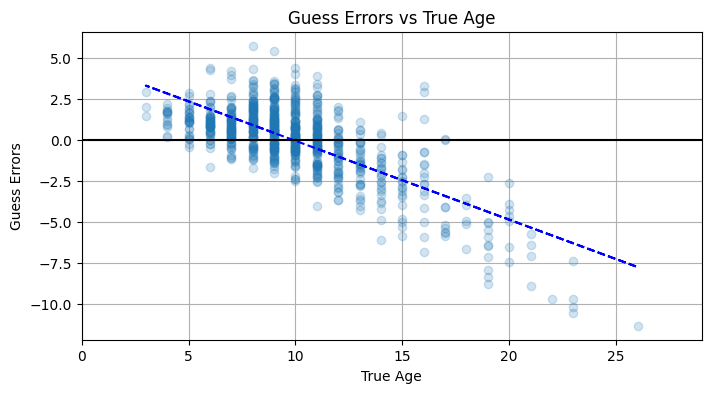

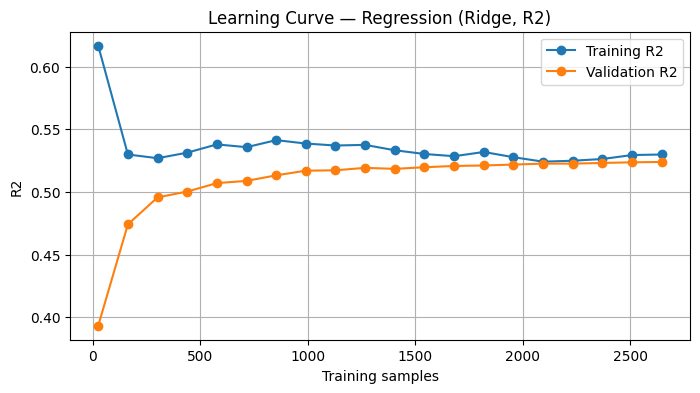

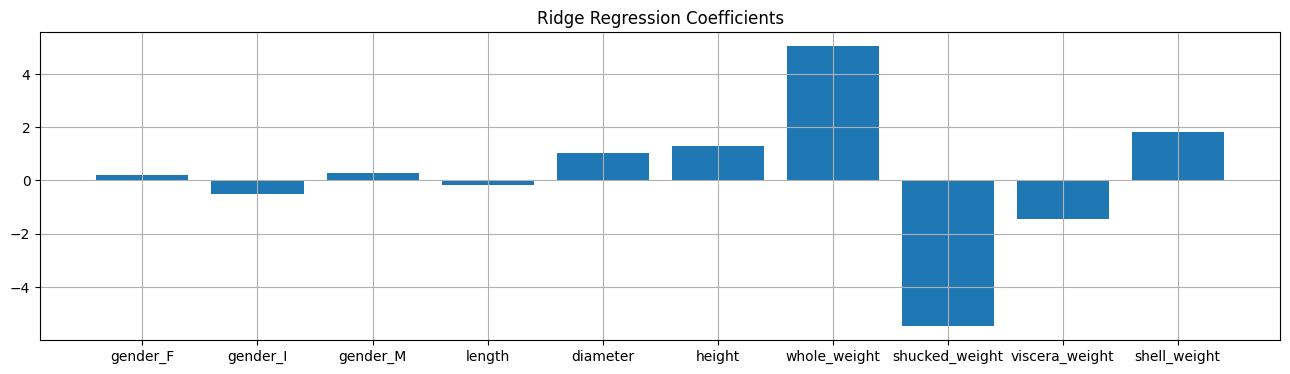

In [11]:

# Define Pipeline
alphaTest = np.logspace(0,10,100)
reg_pipe = Pipeline([
    ("scaler", RobustScaler()), # StandardScaler()),
    ("model", RidgeCV(alphas=alphaTest))
])

# Cross Validate Pipeline
cv_reg = cross_validate(
    reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True
)  

# Fit final pipeline on full training data so coef_ exists
t0 = time.time()
reg_pipe.fit(X_train_r, y_train_r)
train_time_ridge = time.time() - t0

# Print final cross-validation results
print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

# Predict on test data
t1 = time.time()
y_pred_r = reg_pipe.predict(X_test_r)
pred_time_ridge = time.time() - t1

# Evaluate regression model on test data
print("\nRidge Regression Model Evaluation on Test Data:")
rmse_ridge = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
mae_ridge = mean_absolute_error(y_test_r, y_pred_r)
r2_ridge = r2_score(y_test_r, y_pred_r)
print(f"Test RMSE: {rmse_ridge:.3f} | Test MAE: {mae_ridge:.3f} | Test R2: {r2_ridge:.3f}")
print(f"Train time: {train_time_ridge*1000:.1f} ms | Predict time: {pred_time_ridge*1000:.1f} ms")

# Plot Guess errors (residual plot)
plt.figure(figsize=(8, 4))
plt.plot(y_test_r.values, y_pred_r - y_test_r.values, 'o', alpha=0.2)
plt.xlabel("True Age")
plt.ylabel("Guess Errors")
plt.title("Guess Errors vs True Age")
z = np.polyfit(y_test_r, y_pred_r - y_test_r.values, 1)
p = np.poly1d(z)
plt.plot(y_test_r, p(y_test_r), "b--")
plt.axhline(0, 0, np.max(y_test_r), color='black')
plt.grid(True, which='both')
plt.xlim(0, np.max(y_test_r)+3)
plt.show()

# Learning curve (Regression, R2)
train_sizes, train_scores, val_scores = learning_curve(
    reg_pipe, X_train_r, y_train_r, cv=kf, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.01, 1.0, 20), shuffle=True, random_state=RNG
)
plt.figure(figsize=(8, 4))
plt.title("Learning Curve — Regression (Ridge, R2)")
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R2")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation R2")
plt.xlabel("Training samples"); plt.ylabel("R2"); plt.legend(); plt.grid(True)
plt.show()

# Plot coefficients of reg_pipe
coeficients = pd.DataFrame(list(reg_pipe.named_steps["model"].coef_), index=dfEnc.columns[:-1])
plt.figure(figsize=(16, 4))
plt.bar(coeficients.index, coeficients[0])
plt.grid(True, which='both')
plt.title("Ridge Regression Coefficients")
plt.show()